In [ ]:
pip install PyPortfolioOpt

In [ ]:
pip install yfinance

In [ ]:
pip install pulp

In [ ]:
pip install quandl

In [ ]:
import pandas as pd
import numpy as np
import requests
import re
import quandl
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
df= pd.read_csv("capstone_input_data.csv")
df.Date = pd.to_datetime(df.Date, dayfirst = True)
df.set_index("Date", inplace = True)
df.tail()

SBIN.NS  TATAMOTORS.NS  RELIANCE.NS        LT.NS  TATASTEEL.NS
Date                                                                         
2021-08-24  417.600006     279.799988  2183.699951  1605.800049   1404.650024
2021-08-25  416.250000     284.399994  2202.600098  1593.800049   1390.199951
2021-08-26  410.750000     284.299988  2230.449951  1595.750000   1375.050049
2021-08-27  412.450012     285.750000  2227.399902  1638.099976   1384.150024
2021-08-30  422.700012     291.950012  2270.250000  1660.099976   1440.599976

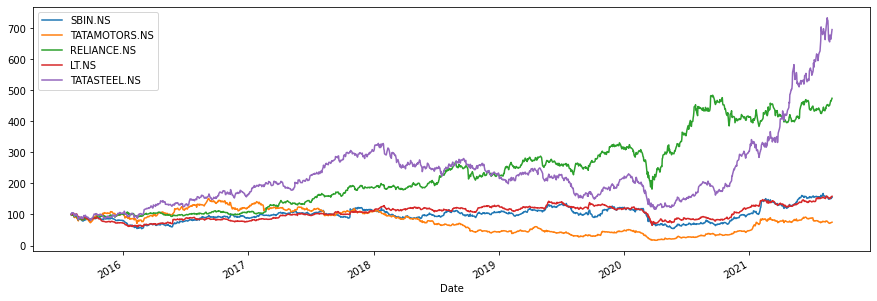

In [ ]:
(df / df.iloc[0] * 100).plot(figsize = (15,5));
plt.show()

In [ ]:
# After installation portfolio optimization package, import the following
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [ ]:
# calculate the expected annualized returns and annualized sample covariance matrix
mu = expected_returns.mean_historical_return(df)
S= risk_models.sample_cov(df) # this gives sample covariance matrix

In [ ]:
# Optimize for the maximal sharpe ratio
ef= EfficientFrontier(mu,S) # create efficient frontier onject
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose= True)

OrderedDict([('SBIN.NS', 0.0), ('TATAMOTORS.NS', 0.0), ('RELIANCE.NS', 0.56966), ('LT.NS', 0.0), ('TATASTEEL.NS', 0.43034)])
Expected annual return: 33.7%
Annual volatility: 28.1%
Sharpe Ratio: 1.13


(0.3372495589442849, 0.2811095658684403, 1.1285619468842911)

In [ ]:
# Dicrete allocation "pip install pulp" already insatlled
# get discreate allocation of each stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
portfolio_val = 10000000
latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=  portfolio_val) #da= discrete allocation
allocation, leftover = da.lp_portfolio() # this will store stock allocation
print('DiscreteAllocation:', allocation)
print('Funds remaining: Rs')

DiscreteAllocation: {'RELIANCE.NS': 2509, 'TATASTEEL.NS': 2987}
Funds remaining: Rs


In [ ]:
# creating a portfolio dataframe
portfolio_df = pd.DataFrame(allocation, index=[0])
portfolio_df

RELIANCE.NS  TATASTEEL.NS
0         2509          2987

In [ ]:
Portfolio_value = 10000000
returns = df.pct_change()
returns = returns[1:]
returns.shape
returns.tail()

SBIN.NS  TATAMOTORS.NS  RELIANCE.NS     LT.NS  TATASTEEL.NS
Date                                                                    
2021-08-24  0.019780       0.010291     0.009873  0.015847      0.033857
2021-08-25 -0.003233       0.016440     0.008655 -0.007473     -0.010287
2021-08-26 -0.013213      -0.000352     0.012644  0.001223     -0.010898
2021-08-27  0.004139       0.005100    -0.001367  0.026539      0.006618
2021-08-30  0.024851       0.021697     0.019238  0.013430      0.040783

In [ ]:
weights = pd.read_csv("weights2.csv")
weights= np.array(weights)
weights.shape

(1, 5)

In [ ]:
pnl = (weights * returns.values).sum(axis=1)
pnl.shape

(1495,)

In [ ]:
historic_var95 = np.percentile(pnl, 5, interpolation = "lower")
historic_var99 = np.percentile(pnl, 1, interpolation = "lower")
historic_var99

-0.0433176289744206

In [ ]:
Daily_VaR95 = Portfolio_value*historic_var95
Monthly_VaR95 = Daily_VaR95 * np.sqrt(22)
Monthly_VaR95

-1172062.2951425663

In [ ]:
Daily_VaR99 = Portfolio_value*historic_var99
Monthly_VaR99 = Daily_VaR99 * np.sqrt(22)
Monthly_VaR99

-2031776.8961980639

In [ ]:
Daily_VaR99 = Portfolio_value*historic_var99
Monthly_VaR99 = Daily_VaR99 * np.sqrt(22)
Monthly_VaR99

-2031776.8961980639

### CVaR

In [ ]:
var_level = 95
var_95 = np.percentile(pnl, 100 - var_level)
cvar_95 = pnl[pnl <= var_95].mean()
cvar_95

-0.03823063245361071

In [ ]:
CVaR_port =cvar_95*Portfolio_value
CVaR_port

-382306.32453610713

In [ ]:
var_level2 = 99
var_99 = np.percentile(pnl, 100 - var_level2)
cvar_99 = pnl[pnl <= var_99].mean()
CVaR_port99 =cvar_99*Portfolio_value
CVaR_port99


-646270.1797729599

In [ ]:
output = [['Portfolio Value', Portfolio_value], ['Daily_VaR_95', Daily_VaR95],['Monthly_VaR95', Monthly_VaR95],['Daily_VaR_99', Daily_VaR99],['Monthly_VaR99', Monthly_VaR99], ['Daily_CVAR_95', CVaR_port],['Daily_CVAR_99', CVaR_port99]] 

In [ ]:
output2 = pd.DataFrame(output, columns=['Details', " Amount in Mn"])
output2

Details   Amount in Mn
0  Portfolio Value   1.000000e+07
1     Daily_VaR_95  -2.498845e+05
2    Monthly_VaR95  -1.172062e+06
3     Daily_VaR_99  -4.331763e+05
4    Monthly_VaR99  -2.031777e+06
5    Daily_CVAR_95  -3.823063e+05
6    Daily_CVAR_99  -6.462702e+05

- VaR is conventionally reported as a positive number. 
- A negative VaR would imply the portfolio has a high probability of making a profit
- For example a one-day 5% VaR of negative 1 million implies the portfolio has a 95 percent chance of making more than 1 million over the next day.